🚀 Multi-Cloud Cost Optimizer with ML Predictions

📈 Step 1: Generating cloud cost data (90 days)...
✓ Generated 270 data points across 3 cloud providers

🤖 Step 2: Training ML cost prediction model...
✓ Model Training Complete
  Training R² Score: 0.9907
  Testing R² Score: 0.9137

📊 Top 5 Cost Drivers:
  cost_per_cpu: 0.4514
  cost_30day_avg: 0.1859
  cost_7day_avg: 0.1684
  is_weekend: 0.0453
  day_of_week: 0.0405

🔮 Step 3: Predicting costs for next 30 days...
✓ Generated predictions for 90 future data points

🔷 MULTI-CLOUD COST OPTIMIZATION REPORT

📊 CURRENT COST ANALYSIS (Last 30 Days)
--------------------------------------------------------------------------------
AWS        | Total: $64,196.50 | Daily Avg: $2,139.88
Azure      | Total: $51,923.46 | Daily Avg: $1,730.78
GCP        | Total: $33,781.09 | Daily Avg: $1,126.04

🔮 COST PREDICTIONS (Next 30 Days)
--------------------------------------------------------------------------------
AWS        | Predicted Total: $50,266.76 | 

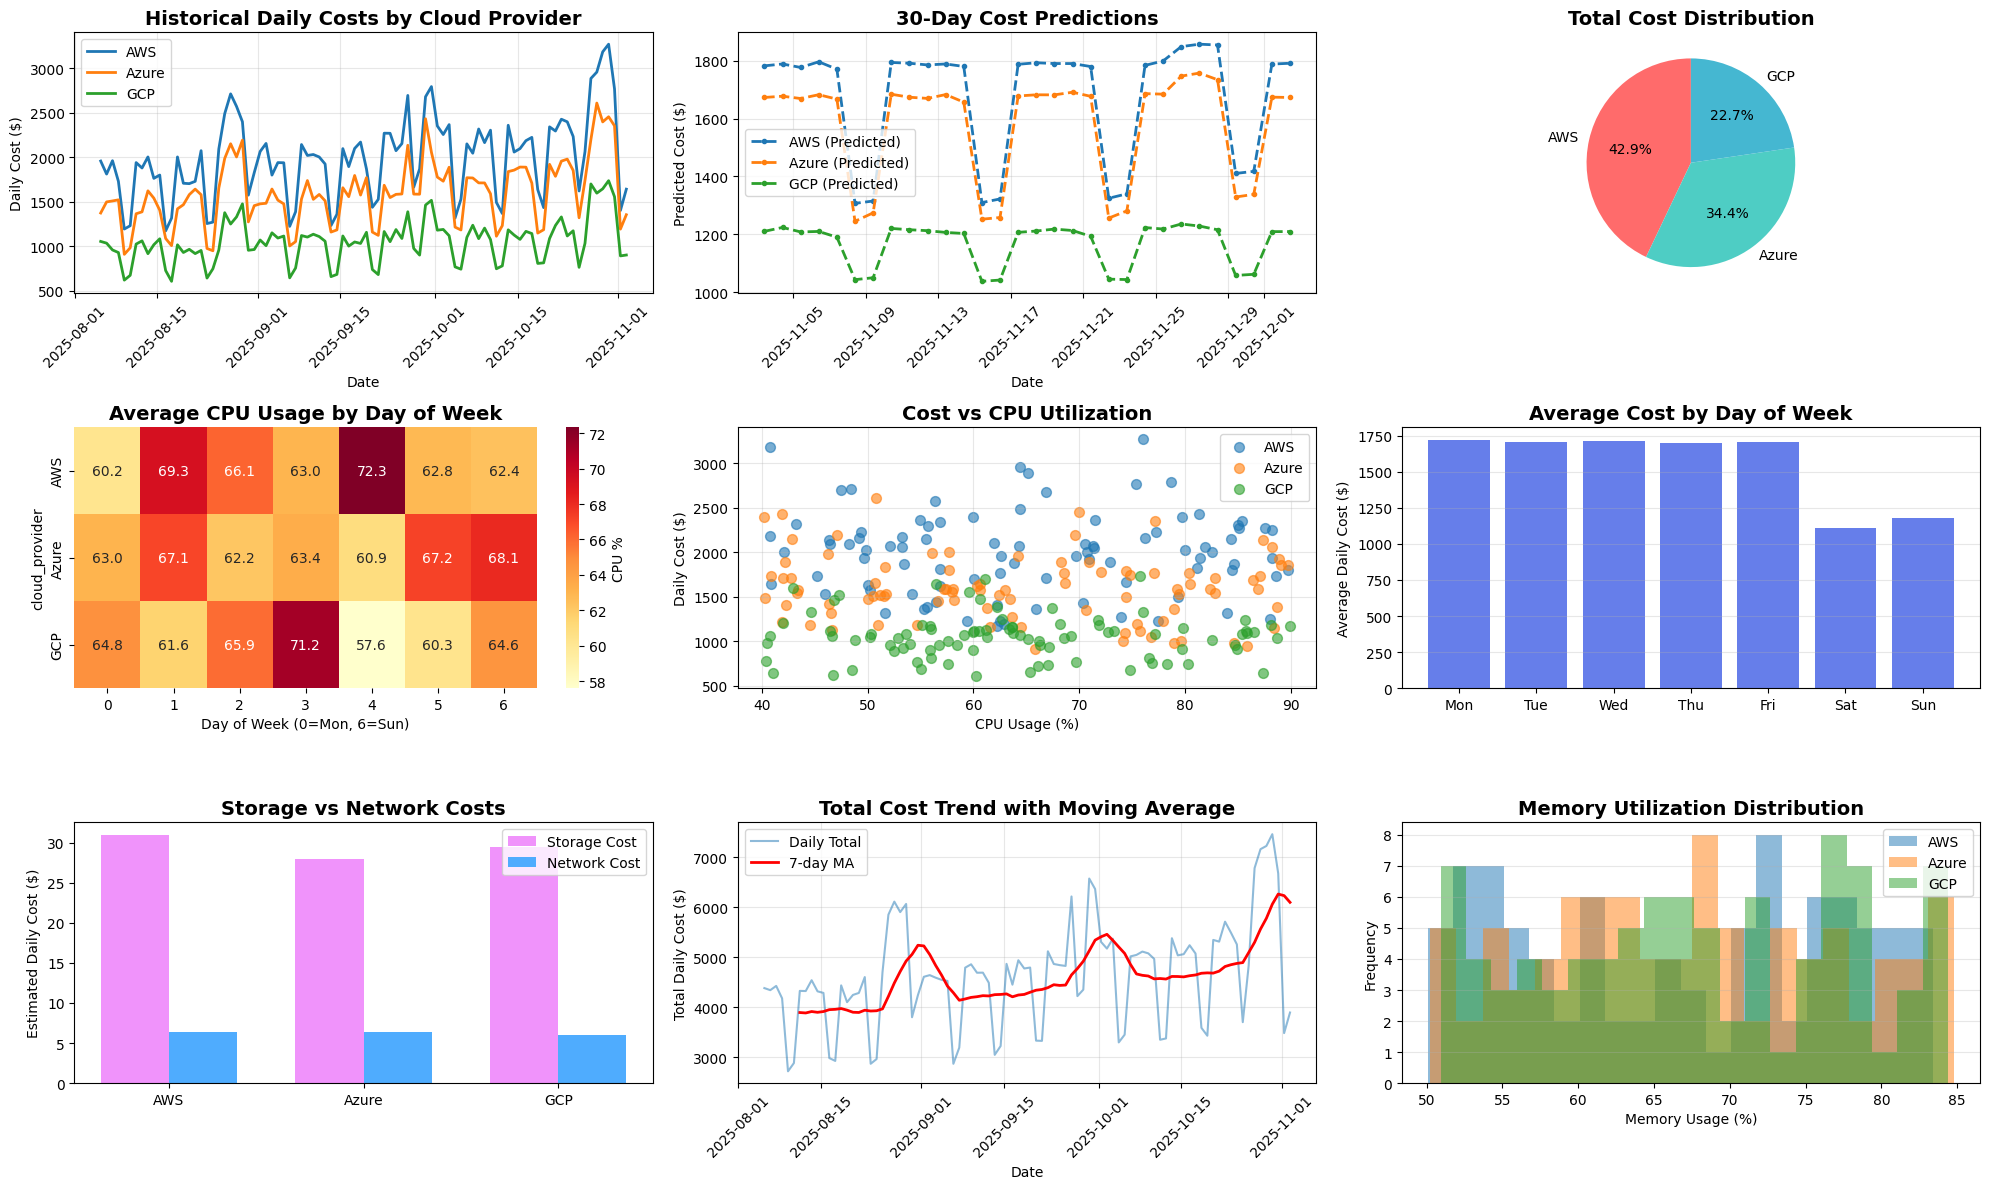


✅ Analysis complete! Check the generated report and visualizations.

📁 Generated files:
  - readme_historical_costs.png
  - readme_predictions.png
  - readme_distribution.png
  - readme_dashboard.png
  - multi_cloud_cost_analysis.png


In [3]:
"""
DevOps Project 1: Multi-Cloud Cost Optimizer with ML Predictions
A sophisticated system that analyzes cloud resource usage patterns and predicts future costs
using machine learning, with automated cost optimization recommendations.
"""

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

class MultiCloudCostOptimizer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.cost_data = None
        self.predictions = None
        self.feature_cols = None

    def generate_cloud_cost_data(self, days=90):
        """Generate realistic cloud cost data for AWS, Azure, and GCP"""
        dates = pd.date_range(end=datetime.now(), periods=days, freq='D')

        # Simulate realistic cost patterns with weekly and monthly cycles
        base_costs = {
            'AWS': 1500,
            'Azure': 1200,
            'GCP': 800
        }

        data = []
        for i, date in enumerate(dates):
            for cloud, base_cost in base_costs.items():
                # Add weekly pattern (higher on weekdays)
                weekly_factor = 1.2 if date.weekday() < 5 else 0.8

                # Add monthly pattern (higher at month end)
                monthly_factor = 1.3 if date.day > 25 else 1.0

                # Add growth trend
                growth_factor = 1 + (i / days) * 0.3

                # Add random variation
                random_factor = np.random.uniform(0.9, 1.1)

                cost = base_cost * weekly_factor * monthly_factor * growth_factor * random_factor

                # Add resource metrics
                cpu_usage = np.random.uniform(40, 90)
                memory_usage = np.random.uniform(50, 85)
                storage_gb = np.random.uniform(100, 500)
                network_gb = np.random.uniform(50, 200)

                data.append({
                    'date': date,
                    'cloud_provider': cloud,
                    'daily_cost': round(cost, 2),
                    'cpu_usage_percent': round(cpu_usage, 2),
                    'memory_usage_percent': round(memory_usage, 2),
                    'storage_gb': round(storage_gb, 2),
                    'network_gb': round(network_gb, 2),
                    'day_of_week': date.weekday(),
                    'day_of_month': date.day,
                    'month': date.month
                })

        self.cost_data = pd.DataFrame(data)
        return self.cost_data

    def engineer_features(self, df, is_prediction=False):
        """Create advanced features for ML model"""
        df = df.copy()

        # Time-based features
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        df['is_month_end'] = (df['day_of_month'] > 25).astype(int)
        df['quarter'] = df['month'].apply(lambda x: (x-1)//3 + 1)

        # Cloud provider encoding
        df['cloud_aws'] = (df['cloud_provider'] == 'AWS').astype(int)
        df['cloud_azure'] = (df['cloud_provider'] == 'Azure').astype(int)
        df['cloud_gcp'] = (df['cloud_provider'] == 'GCP').astype(int)

        # Resource utilization ratios
        df['resource_efficiency'] = (df['cpu_usage_percent'] + df['memory_usage_percent']) / 2
        df['cost_per_cpu'] = df.get('daily_cost', 1000) / (df['cpu_usage_percent'] + 1)
        df['cost_per_storage'] = df.get('daily_cost', 1000) / (df['storage_gb'] + 1)

        # For predictions, use historical averages instead of rolling windows
        if is_prediction:
            # Use the last known values from training data
            for cloud in df['cloud_provider'].unique():
                recent_cloud_data = self.cost_data[self.cost_data['cloud_provider'] == cloud].tail(30)
                avg_cost_7 = recent_cloud_data['daily_cost'].tail(7).mean()
                avg_cost_30 = recent_cloud_data['daily_cost'].mean()

                df.loc[df['cloud_provider'] == cloud, 'cost_7day_avg'] = avg_cost_7
                df.loc[df['cloud_provider'] == cloud, 'cost_30day_avg'] = avg_cost_30
        else:
            # Rolling averages for training data
            df = df.sort_values('date')
            df['cost_7day_avg'] = df.groupby('cloud_provider')['daily_cost'].transform(
                lambda x: x.rolling(7, min_periods=1).mean()
            )
            df['cost_30day_avg'] = df.groupby('cloud_provider')['daily_cost'].transform(
                lambda x: x.rolling(30, min_periods=1).mean()
            )

        return df

    def train_cost_prediction_model(self):
        """Train ML model to predict future costs"""
        df = self.engineer_features(self.cost_data, is_prediction=False)

        # Select features for training
        self.feature_cols = [
            'cpu_usage_percent', 'memory_usage_percent', 'storage_gb', 'network_gb',
            'day_of_week', 'day_of_month', 'month', 'is_weekend', 'is_month_end',
            'quarter', 'cloud_aws', 'cloud_azure', 'cloud_gcp',
            'resource_efficiency', 'cost_per_cpu', 'cost_per_storage',
            'cost_7day_avg', 'cost_30day_avg'
        ]

        X = df[self.feature_cols]
        y = df['daily_cost']

        # Split and train
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.model.fit(X_train_scaled, y_train)

        # Evaluate
        train_score = self.model.score(X_train_scaled, y_train)
        test_score = self.model.score(X_test_scaled, y_test)

        print(f"✓ Model Training Complete")
        print(f"  Training R² Score: {train_score:.4f}")
        print(f"  Testing R² Score: {test_score:.4f}")

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': self.feature_cols,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\n📊 Top 5 Cost Drivers:")
        for idx, row in feature_importance.head().iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")

        return test_score

    def predict_future_costs(self, days_ahead=30):
        """Predict costs for next N days"""
        last_date = self.cost_data['date'].max()
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days_ahead, freq='D')

        predictions = []
        for cloud in ['AWS', 'Azure', 'GCP']:
            recent_data = self.cost_data[self.cost_data['cloud_provider'] == cloud].tail(30)

            for date in future_dates:
                # Use recent averages for prediction
                avg_cpu = recent_data['cpu_usage_percent'].mean()
                avg_memory = recent_data['memory_usage_percent'].mean()
                avg_storage = recent_data['storage_gb'].mean()
                avg_network = recent_data['network_gb'].mean()

                pred_data = pd.DataFrame([{
                    'date': date,
                    'cloud_provider': cloud,
                    'cpu_usage_percent': avg_cpu * np.random.uniform(0.95, 1.05),
                    'memory_usage_percent': avg_memory * np.random.uniform(0.95, 1.05),
                    'storage_gb': avg_storage * np.random.uniform(0.98, 1.02),
                    'network_gb': avg_network * np.random.uniform(0.95, 1.05),
                    'day_of_week': date.weekday(),
                    'day_of_month': date.day,
                    'month': date.month
                }])

                # Engineer features for prediction
                pred_data = self.engineer_features(pred_data, is_prediction=True)

                # Make prediction
                X_pred = self.scaler.transform(pred_data[self.feature_cols])
                predicted_cost = self.model.predict(X_pred)[0]

                predictions.append({
                    'date': date,
                    'cloud_provider': cloud,
                    'predicted_cost': round(predicted_cost, 2)
                })

        self.predictions = pd.DataFrame(predictions)
        return self.predictions

    def generate_optimization_recommendations(self):
        """Generate actionable cost optimization recommendations"""
        recommendations = []

        # Analyze resource utilization
        for cloud in self.cost_data['cloud_provider'].unique():
            cloud_data = self.cost_data[self.cost_data['cloud_provider'] == cloud].tail(30)

            avg_cpu = cloud_data['cpu_usage_percent'].mean()
            avg_memory = cloud_data['memory_usage_percent'].mean()
            avg_cost = cloud_data['daily_cost'].mean()

            # Low utilization recommendations
            if avg_cpu < 50:
                potential_savings = avg_cost * 0.3
                recommendations.append({
                    'cloud': cloud,
                    'type': 'Right-sizing',
                    'priority': 'High',
                    'issue': f'Low CPU utilization ({avg_cpu:.1f}%)',
                    'recommendation': 'Downsize instances by 30-40%',
                    'potential_savings_monthly': round(potential_savings * 30, 2),
                    'implementation': 'Use reserved instances or spot instances'
                })

            if avg_memory < 60:
                potential_savings = avg_cost * 0.2
                recommendations.append({
                    'cloud': cloud,
                    'type': 'Memory Optimization',
                    'priority': 'Medium',
                    'issue': f'Low memory usage ({avg_memory:.1f}%)',
                    'recommendation': 'Reduce memory allocation',
                    'potential_savings_monthly': round(potential_savings * 30, 2),
                    'implementation': 'Switch to memory-optimized instances'
                })

            # Storage optimization
            storage_cost = cloud_data['storage_gb'].mean() * 0.10
            recommendations.append({
                'cloud': cloud,
                'type': 'Storage Optimization',
                'priority': 'Medium',
                'issue': 'Unoptimized storage tiers',
                'recommendation': 'Move cold data to cheaper storage tiers',
                'potential_savings_monthly': round(storage_cost * 30 * 0.4, 2),
                'implementation': 'Implement lifecycle policies'
            })

        return pd.DataFrame(recommendations)

    def save_readme_images(self):
        """Save individual images for README documentation"""
        print("\n📸 Generating images for README...")

        # Image 1: Historical Costs
        plt.figure(figsize=(12, 6))
        for cloud in self.cost_data['cloud_provider'].unique():
            data = self.cost_data[self.cost_data['cloud_provider'] == cloud]
            plt.plot(data['date'], data['daily_cost'], label=cloud, linewidth=2.5, marker='o', markersize=2)
        plt.title('Historical Daily Costs by Cloud Provider', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Daily Cost ($)', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('readme_historical_costs.png', dpi=200, bbox_inches='tight', facecolor='white')
        plt.close()
        print("  ✓ readme_historical_costs.png")

        # Image 2: ML Predictions
        plt.figure(figsize=(12, 6))
        if self.predictions is not None:
            colors = {'AWS': '#FF6B6B', 'Azure': '#4ECDC4', 'GCP': '#45B7D1'}
            for cloud in self.predictions['cloud_provider'].unique():
                data = self.predictions[self.predictions['cloud_provider'] == cloud]
                plt.plot(data['date'], data['predicted_cost'], label=f'{cloud} Predicted',
                        linestyle='--', linewidth=2.5, marker='s', markersize=4, color=colors.get(cloud))
        plt.title('30-Day ML Cost Predictions', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Predicted Cost ($)', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('readme_predictions.png', dpi=200, bbox_inches='tight', facecolor='white')
        plt.close()
        print("  ✓ readme_predictions.png")

        # Image 3: Cost Distribution
        plt.figure(figsize=(10, 8))
        total_costs = self.cost_data.groupby('cloud_provider')['daily_cost'].sum()
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        explode = (0.05, 0.05, 0.05)
        wedges, texts, autotexts = plt.pie(total_costs, labels=total_costs.index, autopct='%1.1f%%',
                colors=colors, startangle=90, textprops={'fontsize': 14, 'weight': 'bold'},
                explode=explode, shadow=True)
        for autotext in autotexts:
            autotext.set_color('white')
        plt.title('Total Cost Distribution Across Cloud Providers', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.savefig('readme_distribution.png', dpi=200, bbox_inches='tight', facecolor='white')
        plt.close()
        print("  ✓ readme_distribution.png")

        # Image 4: Complete Dashboard Preview
        fig = plt.figure(figsize=(16, 10))

        # Subplot 1: Historical
        ax1 = plt.subplot(2, 2, 1)
        for cloud in self.cost_data['cloud_provider'].unique():
            data = self.cost_data[self.cost_data['cloud_provider'] == cloud].tail(30)
            ax1.plot(data['date'], data['daily_cost'], label=cloud, linewidth=2)
        ax1.set_title('Historical Costs (30 days)', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=9)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45, labelsize=8)

        # Subplot 2: Predictions
        ax2 = plt.subplot(2, 2, 2)
        if self.predictions is not None:
            for cloud in self.predictions['cloud_provider'].unique():
                data = self.predictions[self.predictions['cloud_provider'] == cloud].head(15)
                ax2.plot(data['date'], data['predicted_cost'], label=f'{cloud}', linestyle='--', linewidth=2)
        ax2.set_title('Cost Predictions (15 days)', fontsize=12, fontweight='bold')
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45, labelsize=8)

        # Subplot 3: Weekly Pattern
        ax3 = plt.subplot(2, 2, 3)
        weekly_costs = self.cost_data.groupby('day_of_week')['daily_cost'].mean()
        days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        bars = ax3.bar(days, weekly_costs.values, color=['#667eea']*5 + ['#f093fb']*2)
        ax3.set_title('Average Cost by Weekday', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Avg Cost ($)')
        ax3.grid(True, alpha=0.3, axis='y')

        # Subplot 4: Efficiency
        ax4 = plt.subplot(2, 2, 4)
        for cloud in self.cost_data['cloud_provider'].unique():
            data = self.cost_data[self.cost_data['cloud_provider'] == cloud].tail(50)
            ax4.scatter(data['cpu_usage_percent'], data['daily_cost'], label=cloud, alpha=0.6, s=30)
        ax4.set_title('Cost vs CPU Utilization', fontsize=12, fontweight='bold')
        ax4.set_xlabel('CPU Usage (%)')
        ax4.set_ylabel('Daily Cost ($)')
        ax4.legend(fontsize=9)
        ax4.grid(True, alpha=0.3)

        plt.suptitle('Complete Cost Analysis Dashboard', fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig('readme_dashboard.png', dpi=200, bbox_inches='tight', facecolor='white')
        plt.close()
        print("  ✓ readme_dashboard.png")

        print("\n✅ All README images generated successfully!")

    def visualize_analysis(self):
        """Create comprehensive visualization of cost analysis"""
        fig = plt.figure(figsize=(20, 12))

        # 1. Historical costs by cloud
        ax1 = plt.subplot(3, 3, 1)
        for cloud in self.cost_data['cloud_provider'].unique():
            data = self.cost_data[self.cost_data['cloud_provider'] == cloud]
            ax1.plot(data['date'], data['daily_cost'], label=cloud, linewidth=2)
        ax1.set_title('Historical Daily Costs by Cloud Provider', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Daily Cost ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)

        # 2. Cost predictions
        ax2 = plt.subplot(3, 3, 2)
        if self.predictions is not None:
            for cloud in self.predictions['cloud_provider'].unique():
                data = self.predictions[self.predictions['cloud_provider'] == cloud]
                ax2.plot(data['date'], data['predicted_cost'], label=f'{cloud} (Predicted)',
                        linestyle='--', linewidth=2, marker='o', markersize=3)
        ax2.set_title('30-Day Cost Predictions', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Predicted Cost ($)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)

        # 3. Total cost by cloud
        ax3 = plt.subplot(3, 3, 3)
        total_costs = self.cost_data.groupby('cloud_provider')['daily_cost'].sum()
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        ax3.pie(total_costs, labels=total_costs.index, autopct='%1.1f%%', colors=colors, startangle=90)
        ax3.set_title('Total Cost Distribution', fontsize=14, fontweight='bold')

        # 4. Resource utilization heatmap
        ax4 = plt.subplot(3, 3, 4)
        pivot_data = self.cost_data.pivot_table(
            values='cpu_usage_percent',
            index='cloud_provider',
            columns='day_of_week',
            aggfunc='mean'
        )
        sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'CPU %'})
        ax4.set_title('Average CPU Usage by Day of Week', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Day of Week (0=Mon, 6=Sun)')

        # 5. Cost efficiency scatter
        ax5 = plt.subplot(3, 3, 5)
        for cloud in self.cost_data['cloud_provider'].unique():
            data = self.cost_data[self.cost_data['cloud_provider'] == cloud]
            ax5.scatter(data['cpu_usage_percent'], data['daily_cost'],
                       label=cloud, alpha=0.6, s=50)
        ax5.set_title('Cost vs CPU Utilization', fontsize=14, fontweight='bold')
        ax5.set_xlabel('CPU Usage (%)')
        ax5.set_ylabel('Daily Cost ($)')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # 6. Weekly cost patterns
        ax6 = plt.subplot(3, 3, 6)
        weekly_costs = self.cost_data.groupby('day_of_week')['daily_cost'].mean()
        days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        ax6.bar(days, weekly_costs.values, color='#667eea')
        ax6.set_title('Average Cost by Day of Week', fontsize=14, fontweight='bold')
        ax6.set_ylabel('Average Daily Cost ($)')
        ax6.grid(True, alpha=0.3, axis='y')

        # 7. Storage vs Network costs
        ax7 = plt.subplot(3, 3, 7)
        storage_costs = self.cost_data.groupby('cloud_provider')['storage_gb'].mean() * 0.10
        network_costs = self.cost_data.groupby('cloud_provider')['network_gb'].mean() * 0.05
        x = np.arange(len(storage_costs))
        width = 0.35
        ax7.bar(x - width/2, storage_costs, width, label='Storage Cost', color='#f093fb')
        ax7.bar(x + width/2, network_costs, width, label='Network Cost', color='#4facfe')
        ax7.set_title('Storage vs Network Costs', fontsize=14, fontweight='bold')
        ax7.set_xticks(x)
        ax7.set_xticklabels(storage_costs.index)
        ax7.legend()
        ax7.set_ylabel('Estimated Daily Cost ($)')

        # 8. Cost trend with moving average
        ax8 = plt.subplot(3, 3, 8)
        total_daily = self.cost_data.groupby('date')['daily_cost'].sum()
        ax8.plot(total_daily.index, total_daily.values, label='Daily Total', alpha=0.5)
        ax8.plot(total_daily.index, total_daily.rolling(7).mean(),
                label='7-day MA', linewidth=2, color='red')
        ax8.set_title('Total Cost Trend with Moving Average', fontsize=14, fontweight='bold')
        ax8.set_xlabel('Date')
        ax8.set_ylabel('Total Daily Cost ($)')
        ax8.legend()
        ax8.grid(True, alpha=0.3)
        ax8.tick_params(axis='x', rotation=45)

        # 9. Memory utilization distribution
        ax9 = plt.subplot(3, 3, 9)
        for cloud in self.cost_data['cloud_provider'].unique():
            data = self.cost_data[self.cost_data['cloud_provider'] == cloud]
            ax9.hist(data['memory_usage_percent'], bins=20, alpha=0.5, label=cloud)
        ax9.set_title('Memory Utilization Distribution', fontsize=14, fontweight='bold')
        ax9.set_xlabel('Memory Usage (%)')
        ax9.set_ylabel('Frequency')
        ax9.legend()
        ax9.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig('multi_cloud_cost_analysis.png', dpi=300, bbox_inches='tight')
        print("\n✓ Visualization saved as 'multi_cloud_cost_analysis.png'")
        plt.show()

    def generate_report(self):
        """Generate comprehensive cost optimization report"""
        print("\n" + "="*80)
        print("🔷 MULTI-CLOUD COST OPTIMIZATION REPORT")
        print("="*80)

        # Current costs
        print("\n📊 CURRENT COST ANALYSIS (Last 30 Days)")
        print("-" * 80)
        recent_data = self.cost_data.tail(30 * 3)
        for cloud in recent_data['cloud_provider'].unique():
            cloud_data = recent_data[recent_data['cloud_provider'] == cloud]
            total = cloud_data['daily_cost'].sum()
            avg = cloud_data['daily_cost'].mean()
            print(f"{cloud:10} | Total: ${total:,.2f} | Daily Avg: ${avg:,.2f}")

        # Predictions
        if self.predictions is not None:
            print("\n🔮 COST PREDICTIONS (Next 30 Days)")
            print("-" * 80)
            for cloud in self.predictions['cloud_provider'].unique():
                cloud_pred = self.predictions[self.predictions['cloud_provider'] == cloud]
                predicted_total = cloud_pred['predicted_cost'].sum()
                predicted_avg = cloud_pred['predicted_cost'].mean()
                print(f"{cloud:10} | Predicted Total: ${predicted_total:,.2f} | Daily Avg: ${predicted_avg:,.2f}")

        # Recommendations
        print("\n💡 OPTIMIZATION RECOMMENDATIONS")
        print("-" * 80)
        recommendations = self.generate_optimization_recommendations()
        total_savings = recommendations['potential_savings_monthly'].sum()

        for idx, rec in recommendations.iterrows():
            print(f"\n{rec['cloud']} - {rec['type']} [{rec['priority']} Priority]")
            print(f"  Issue: {rec['issue']}")
            print(f"  Action: {rec['recommendation']}")
            print(f"  Implementation: {rec['implementation']}")
            print(f"  Potential Monthly Savings: ${rec['potential_savings_monthly']:,.2f}")

        print(f"\n{'='*80}")
        print(f"💰 TOTAL POTENTIAL MONTHLY SAVINGS: ${total_savings:,.2f}")
        print(f"💰 ANNUAL SAVINGS POTENTIAL: ${total_savings * 12:,.2f}")
        print(f"{'='*80}\n")

# Main execution
def main():
    print("🚀 Multi-Cloud Cost Optimizer with ML Predictions")
    print("=" * 80)

    optimizer = MultiCloudCostOptimizer()

    # Step 1: Generate and analyze data
    print("\n📈 Step 1: Generating cloud cost data (90 days)...")
    cost_data = optimizer.generate_cloud_cost_data(days=90)
    print(f"✓ Generated {len(cost_data)} data points across 3 cloud providers")

    # Step 2: Train ML model
    print("\n🤖 Step 2: Training ML cost prediction model...")
    optimizer.train_cost_prediction_model()

    # Step 3: Predict future costs
    print("\n🔮 Step 3: Predicting costs for next 30 days...")
    predictions = optimizer.predict_future_costs(days_ahead=30)
    print(f"✓ Generated predictions for {len(predictions)} future data points")

    # Step 4: Generate report
    optimizer.generate_report()

    # Step 5: Generate README images
    print("\n📊 Step 5: Creating visualizations...")
    optimizer.save_readme_images()

    # Step 6: Complete dashboard
    print("\n📊 Step 6: Creating complete dashboard...")
    optimizer.visualize_analysis()

    print("\n✅ Analysis complete! Check the generated report and visualizations.")
    print("\n📁 Generated files:")
    print("  - readme_historical_costs.png")
    print("  - readme_predictions.png")
    print("  - readme_distribution.png")
    print("  - readme_dashboard.png")
    print("  - multi_cloud_cost_analysis.png")

if __name__ == "__main__":
    main()